## This notebook has functions to trim/fade samples, then to plot them as waveforms(time), spectrums, and spectrograms. The batch processing section handles multiple files, plot types, and folders.
---------------------------------------------------------------

### Imports



In [69]:
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
import scipy
from scipy import signal
from datetime import datetime
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

### Constants / Config

In [3]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load

SPEC_PARAMS = {
    'linear_freq_decibels': {
        'n_fft_ms': 100,
        'hop_length_ms': 1,
        'y_scale': 'linear',
        'amplitude': 'db',
    },
    'log_freq_decibels': {
        'n_fft_ms': 200,
        'hop_length_ms': 1,
        'y_scale': 'log',
        'amplitude': 'db',
    },
    'linear_freq_linear_amp': {
        'n_fft_ms': 100,
        'hop_length_ms': 1,
        'y_scale': 'linear',
        'amplitude': 'linear',
    },
    'log_freq_linear_amp': {
        'n_fft_ms': 200,
        'hop_length_ms': 1,
        'y_scale': 'log',
        'amplitude': 'linear',
    }
}


PLOT_HEIGHT = 4  # Height in inches for each plot
PLOT_WIDTH = 12  # Width in inches for all plots
SUBPLOT_SPACING = 0.4

### Utility Function Definitions



In [4]:
def trim(y, sr, start_seconds, end_seconds):
    # Convert start and end times to samples
    start_sample = int(start_seconds * sr)
    end_sample = int(end_seconds * sr)
    
    # Trim the audio
    y = y[start_sample:end_sample]
    
    return y         

In [5]:
def apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS):
    """
    Apply Hann window to the audio signal
    
    Parameters:
    - y: numpy array of audio samples
    - sr: the samplerate
    - FADE_DURATION_SECONDS: length of the window to apply in s
    
    Returns:
    - windowed audio signal
    """
    
    window_samples = int(FADE_DURATION_SECONDS * sr)


    # Create Hann window
    hann_window = np.hanning(window_samples * 2)
    
    # Split window into fade-in and fade-out
    fade_in = hann_window[:window_samples]
    fade_out = hann_window[window_samples:]
    
    # Apply fade-in to the beginning
    y[:window_samples] *= fade_in
    
    # Apply fade-out to the end
    y[-window_samples:] *= fade_out
    
    return y

### Plotting Function Definitions



In [6]:
def plot_spectrogram(y, sr, fig, ax, n_fft_ms=100, hop_length_ms=1, y_scale='linear', 
                    amplitude='db', title=None):
    """Plot a spectrogram with specified frequency and amplitude scaling.
    
    Parameters:
    -----------
    y : np.ndarray
        Audio signal
    sr : int
        Sample rate in Hz
    fig : matplotlib.figure.Figure
        Figure object for the plot
    ax : matplotlib.axes.Axes
        Axes object to plot on
    n_fft_ms : int, optional
        FFT window size in milliseconds (default: 100)
    hop_length_ms : int, optional
        Number of milliseconds between successive frames (default: 1)
    y_scale : {'linear', 'log'}, optional
        Frequency axis scaling (default: 'linear')
        - 'linear': Shows 0-2000 Hz with linear spacing
        - 'log': Shows 20-20000 Hz with logarithmic spacing
    amplitude : {'db', 'linear'}, optional
        Amplitude scaling (default: 'db')
        - 'db': Shows amplitude in decibels (-80 to 0 dB)
        - 'linear': Shows normalized linear amplitude (0 to 1)
    title : str, optional
        Plot title (default: None)
    """
    
    
    # Convert ms to samples
    n_fft = int(n_fft_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    
    # Compute STFT
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # Apply amplitude scaling
    if amplitude == 'db':
        D = librosa.amplitude_to_db(D, ref=np.max)  # Reference to max for consistent scaling
        vmin, vmax = -80, 0  # Standard dB range
        colorbar_format = '%+2.f dB'
    else:
        # Normalize linear amplitude to 0-1 range
        D = D / np.max(np.abs(D))
        vmin, vmax = 0, 1
        colorbar_format = '%.2f'
    
    # Plot spectrogram
    img = librosa.display.specshow(D, y_axis=y_scale, x_axis='time', 
                                 hop_length=hop_length, sr=sr, ax=ax,
                                 cmap='viridis', vmin=vmin, vmax=vmax)
    
    # Configure frequency axis
    ax.tick_params(axis='y', which='minor', left=False)
    nyquist = sr/2
    
    if y_scale == 'linear':
        ax.set_ylim(0, 2000)
        ax.set_yticks(range(0, 2100, 100))
    else:  # log scale
        if nyquist > 20000:
            ax.set_ylim(20, 20000)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000])
        else:
            ax.set_ylim(20, nyquist)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, nyquist])
    
    # Set title
    plot_type = f"{'Linear' if y_scale=='linear' else 'Log'}-freq, {'dB' if amplitude=='db' else 'Linear'}-amplitude"
    ax.set_title(f"{plot_type} spectrogram: {title}" if title else f"{plot_type} spectrogram", pad=15)
    
    # Add colorbar
    fig.colorbar(img, ax=ax, format=colorbar_format)

In [7]:
def plot_spectrum(y, sr, fig, ax, title=None):
    """Plot magnitude spectrum with frequency axis in Hz."""
    
    # Perform FFT and calculate amplitude
    ft = np.fft.rfft(y)  # Already gives just the positive frequencies
    freqs = np.fft.rfftfreq(len(y), 1/sr)  # Frequencies for rfft
    magnitude_spectrum = np.abs(ft)  # No need to slice
    
    # Convert magnitude to decibels
    magnitude_db = librosa.amplitude_to_db(magnitude_spectrum, ref=np.max)
    
    # Plot the spectrum
    img = ax.plot(freqs, magnitude_db)
    
    # Set log scale and ticks
    ax.set_xscale('log')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', alpha=0.3)

    if (20000 < (sr/2)):
        ax.set_xlim(20, 20000)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)    
    else:
        ax.set_xlim(20, sr/2)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks) 

    
    ax.set_ylim(-80, 0)  

    
    # Labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (dB)')
    if title:
        ax.set_title(f"Spectrum: {title}", pad=15) 
    else:
        ax.set_title('Spectrum', pad=15) 



In [77]:
def plot_csd(x, y, sr, fig, ax, title=None):
    """Plot cross-spectral density with frequency axis in Hz."""
    
    # Compute CSD using scipy.signal
    f, Pxy = signal.csd(x, y, fs=sr, scaling='spectrum', nperseg=4096)
    
    # Plot the magnitude spectrum using semilogy (log scale on y-axis)
    img = ax.semilogy(f, np.abs(Pxy))
    
    # Set log scale for x-axis and ticks
    ax.set_xscale('log')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', alpha=0.3)

    if (20000 < (sr/2)):
        ax.set_xlim(20, 20000)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)    
    else:
        ax.set_xlim(20, sr/2)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks) 

    # Labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('CSD Magnitude')
    if title:
        ax.set_title(f"CSD: {title}", pad=15) 
    else:
        ax.set_title('Cross-spectral Density', pad=15)

In [8]:
def plot_time(y, sr, fig, ax, title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color='#1f77b4', linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(f"Waveform: {title}", pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    

In [9]:
def create_specs_page(pdf, plot_type=None, input_folders=None, multi_plot=False):
    """Creates a cover page with processing specifications.
    
    Parameters:
    -----------
    pdf : PdfPages
        PDF document to write to
    plot_type : str, optional
        Type of plot being generated (for single plot mode)
    input_folders : str or list
        Input folder(s) being processed
    multi_plot : bool
        Whether multiple plot types are being generated per file
    """
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    
    # Add header with title and timestamp
    header = [
        f"York Tuba Analysis",
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"\n"  # Extra spacing after header
    ]
    
    # Basic processing parameters
    params = [
        f"Processing Parameters",
        f"-------------------",
        f"Sample Rate: {SAMPLE_RATE} Hz",
        f"Trim Duration: {TRIM_DURATION_SECONDS} seconds",
        f"Fade Duration: {FADE_DURATION_SECONDS*1000:.1f} ms",
    ]
    
    if multi_plot:
        params.extend([
            f"\nSpectrogram Parameters",
            f"-------------------",
            f"Linear Frequency Analysis:",
            f"• FFT Window: {SPEC_PARAMS['linear_freq_decibels']['n_fft_ms']} ms",
            f"• Hop Length: {SPEC_PARAMS['linear_freq_decibels']['hop_length_ms']} ms",
            f"• Frequency Range: 0-2000 Hz",
            f"• Available Amplitude Scales:",
            f"  - Linear: 0-1 (normalized)",
            f"  - Decibels: -80-0 dB",
            
            f"\nLog Frequency Analysis:",
            f"• FFT Window: {SPEC_PARAMS['log_freq_decibels']['n_fft_ms']} ms",
            f"• Hop Length: {SPEC_PARAMS['log_freq_decibels']['hop_length_ms']} ms",
            f"• Frequency Range: 20-20000 Hz",
            f"• Available Amplitude Scales:",
            f"  - Linear: 0-1 (normalized)",
            f"  - Decibels: -80-0 dB",
            
            f"\nSpectrum Analysis:",
            f"• Window: {TRIM_DURATION_SECONDS*1000:.0f} ms",
            f"• Frequency Scale: Log",
            f"• Frequency Range: 20-20000 Hz",
            f"• Amplitude Scale: Decibels (-80-0 dB)",
            
            f"\nTime Domain Analysis:",
            f"• Duration: {TRIM_DURATION_SECONDS*1000:.0f} ms",
            f"• Samples: {int(TRIM_DURATION_SECONDS * SAMPLE_RATE)}"
        ])
        
    elif plot_type:
        if plot_type in PLOT_TYPE_TO_PARAMS:
            spec_key = PLOT_TYPE_TO_PARAMS[plot_type]
            spec_params = SPEC_PARAMS[spec_key]
            freq_range = "0-2000 Hz" if spec_params['y_scale']=='linear' else "20-20000 Hz"
            amp_range = "0-1 (normalized)" if spec_params['amplitude']=='linear' else "-80-0 dB"
            
            params.extend([
                f"\nSpectrogram Configuration",
                f"-------------------",
                f"FFT Window: {spec_params['n_fft_ms']} ms",
                f"Hop Length: {spec_params['hop_length_ms']} ms",
                f"Frequency Scale: {spec_params['y_scale'].capitalize()}, {freq_range}",
                f"Amplitude Scale: {spec_params['amplitude'].capitalize()}, {amp_range}"
            ])
        elif plot_type == 'SPECTRUM':
            params.extend([
                f"\nSpectrum Configuration",
                f"-------------------",
                f"Window: {TRIM_DURATION_SECONDS*1000:.0f} ms",
                f"Frequency Scale: Log",
                f"Frequency Range: 20-20000 Hz",
                f"Amplitude Scale: Decibels (-80-0 dB)"
            ])
        elif plot_type == 'TIME':
            params.extend([
                f"\nTime Domain Configuration",
                f"-------------------",
                f"Duration: {TRIM_DURATION_SECONDS*1000:.0f} ms",
                f"Samples: {int(TRIM_DURATION_SECONDS * SAMPLE_RATE)}"
            ])
    
   # Add input folder information if provided
    if input_folders:
        params.extend([
            f"\nInput Folders",
            f"-------------------"
        ])
        if isinstance(input_folders, list):
            # List full paths
            params.extend([f"• {folder}" for folder in sorted(input_folders)])
        else:
            params.append(f"• {input_folders}")
    
    # Combine header and params with proper spacing
    all_text = header + params
    
    plt.text(0.1, 0.95, '\n'.join(all_text), 
             transform=fig.transFigure,
             fontsize=12,
             verticalalignment='top',
             fontfamily='monospace')
    
    pdf.savefig(fig)
    plt.close(fig)

### Single file run (with example.wav)




In [70]:
file = 'example.wav'
y, sr = librosa.load(file,sr=22050)
title = os.path.basename(file) 

y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS) 
# Create fig and ax objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

plot_spectrogram(y, sr, fig, ax1, **SPEC_PARAMS['linear_freq_linear_amp'], title=title)
plot_spectrogram(y, sr, fig, ax2, **SPEC_PARAMS['log_freq_linear_amp'], title=title)
plot_spectrogram(y, sr, fig, ax3, **SPEC_PARAMS['linear_freq_decibels'], title=title)
plot_spectrogram(y, sr, fig, ax4, **SPEC_PARAMS['log_freq_decibels'], title=title)


# plot_spectrum(y, sr, fig, ax3, title=title)
# plot_time(y, sr, fig, ax4, title=title)

plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
Audio(y, rate=sr)

KeyboardInterrupt: 

### Batch processing




##### PDF Option 1: All plot types per audio file in folder

In [18]:


INPUT_FOLDER = './samples/singlenotes/york/aom5024/'
OUTPUT_PATH = './PDFs/york/york_notes_aom5024.pdf'

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:
    # Create the specs page
    create_specs_page(pdf, input_folders=INPUT_FOLDER, multi_plot=True)

    # Process all wav files in folder alphabetically
    wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))
    for file in wav_files:
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        title = os.path.basename(file)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        
        # Create a figure with six subplots
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(PLOT_WIDTH, PLOT_HEIGHT * 6))
        
        # Create plots in subplots
        plot_spectrogram(y, sr, fig, ax1, **SPEC_PARAMS['linear_freq_linear_amp'], title=title)
        plot_spectrogram(y, sr, fig, ax2, **SPEC_PARAMS['log_freq_linear_amp'], title=title)
        plot_spectrogram(y, sr, fig, ax3, **SPEC_PARAMS['linear_freq_decibels'], title=title)
        plot_spectrogram(y, sr, fig, ax4, **SPEC_PARAMS['log_freq_decibels'], title=title)
        plot_spectrum(y, sr, fig, ax5, title=title)
        plot_time(y, sr, fig, ax6, title=title)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 2: Same plot type across multiple files


In [19]:

# Configuration
# Available plot types:
# SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP
# SPECTROGRAM-LINEAR-FREQ-DECIBELS
# SPECTROGRAM-LOG-FREQ-LINEAR-AMP
# SPECTROGRAM-LOG-FREQ-DECIBELS
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM-LOG-FREQ-DECIBELS'
INPUT_FOLDER = './samples/singlenotes/york/aom5024/'
OUTPUT_PATH = f'./PDFs/York/{PLOT_TYPE}_aom5024.pdf'
ROWS = 2
COLUMNS = 1
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Map plot types to SPEC_PARAMS keys
PLOT_TYPE_TO_PARAMS = {
    'SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP': 'linear_freq_linear_amp',
    'SPECTROGRAM-LINEAR-FREQ-DECIBELS': 'linear_freq_decibels',
    'SPECTROGRAM-LOG-FREQ-LINEAR-AMP': 'log_freq_linear_amp',
    'SPECTROGRAM-LOG-FREQ-DECIBELS': 'log_freq_decibels'
}

with PdfPages(OUTPUT_PATH) as pdf:
    # Create specs page
    create_specs_page(pdf, plot_type=PLOT_TYPE, input_folders=INPUT_FOLDER)
    
    # Create initial figure
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
    axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
    plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
    plot_count = 0

    for file in sorted(Path(INPUT_FOLDER).glob('*.wav')):
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        title = os.path.basename(file)
        
        # Make plot based on type
        if PLOT_TYPE in PLOT_TYPE_TO_PARAMS:
            plot_spectrogram(y, sr, fig, axes[plot_count], 
                           **SPEC_PARAMS[PLOT_TYPE_TO_PARAMS[PLOT_TYPE]], 
                           title=title)
        elif PLOT_TYPE == 'SPECTRUM':
            plot_spectrum(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'TIME':
            plot_time(y, sr, fig, axes[plot_count], title=title)
        
        plot_count += 1
        
        if plot_count == PLOTS_PER_PAGE:
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
            axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
            plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
            plot_count = 0
    
    if plot_count > 0:
        # Hide empty subplots
        for i in range(plot_count, PLOTS_PER_PAGE):
            axes[i].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 3: Compare files across folders with same plot type


In [66]:
# Configuration
# Available plot types:
# SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP
# SPECTROGRAM-LINEAR-FREQ-DECIBELS
# SPECTROGRAM-LOG-FREQ-LINEAR-AMP
# SPECTROGRAM-LOG-FREQ-DECIBELS
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM-LOG-FREQ-DECIBELS'
INPUT_FOLDERS = [
   './samples/singlenotes/yamaha/sm57/',
   './samples/singlenotes/york/sm57/',
   # Add more folders here as needed
]
OUTPUT_PATH = f'./PDFs/SingleNoteComparisons/{PLOT_TYPE.lower()}_comparison.pdf'

# Map plot types to SPEC_PARAMS keys
PLOT_TYPE_TO_PARAMS = {
    'SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP': 'linear_freq_linear_amp',
    'SPECTROGRAM-LINEAR-FREQ-DECIBELS': 'linear_freq_decibels',
    'SPECTROGRAM-LOG-FREQ-LINEAR-AMP': 'log_freq_linear_amp',
    'SPECTROGRAM-LOG-FREQ-DECIBELS': 'log_freq_decibels'
}

# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:
    create_specs_page(pdf, plot_type=PLOT_TYPE, input_folders=INPUT_FOLDERS)

    for i in range(max(len(f) for f in files)):
        fig, axes = plt.subplots(len(INPUT_FOLDERS), 1, 
                           figsize=(PLOT_WIDTH, PLOT_HEIGHT * len(INPUT_FOLDERS)))
        axes = [axes] if len(INPUT_FOLDERS) == 1 else axes  # Handle single folder case
        plt.subplots_adjust(hspace=SUBPLOT_SPACING)
        
        for ax, folder_files, name in zip(axes, files, folder_names):
            if i < len(folder_files):
                y, sr = librosa.load(str(folder_files[i]), sr=SAMPLE_RATE)
                y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
                y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
                title = folder_files[i].name
                
                if PLOT_TYPE in PLOT_TYPE_TO_PARAMS:
                    plot_spectrogram(y, sr, fig, ax, 
                                   **SPEC_PARAMS[PLOT_TYPE_TO_PARAMS[PLOT_TYPE]], 
                                   title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, ax, title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, ax, title=title)
            else:
                ax.text(0.5, 0.5, f'No more files in {name} folder', ha='center', va='center')
                ax.set_title(f"{name} (empty)")
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 4: plot entire Audio_DEMOS scales

In [68]:
# Configuration
# Available plot types:
# SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP
# SPECTROGRAM-LINEAR-FREQ-DECIBELS
# SPECTROGRAM-LOG-FREQ-LINEAR-AMP
# SPECTROGRAM-LOG-FREQ-DECIBELS
# SPECTRUM
# TIME
PLOT_TYPE = 'SPECTROGRAM-LOG-FREQ-DECIBELS'
INPUT_FOLDERS = ['samples/performance/aom5024']
OUTPUT_PATH = f'./PDFs/PerformanceComparisons/aom5024/{PLOT_TYPE.lower()}_performance_comparison.pdf'

# Map plot types to SPEC_PARAMS keys
PLOT_TYPE_TO_PARAMS = {
    'SPECTROGRAM-LINEAR-FREQ-LINEAR-AMP': 'linear_freq_linear_amp',
    'SPECTROGRAM-LINEAR-FREQ-DECIBELS': 'linear_freq_decibels',
    'SPECTROGRAM-LOG-FREQ-LINEAR-AMP': 'log_freq_linear_amp',
    'SPECTROGRAM-LOG-FREQ-DECIBELS': 'log_freq_decibels'
}

# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:
    #  grid dimensions 
    n_rows = 2
    n_cols = 1
    plots_per_page = n_rows * n_cols
    
    # Calculate how many pages we need
    total_files = len(files[0])  # Assuming we're using files from the first folder
    n_pages = (total_files + plots_per_page - 1) // plots_per_page
    
    for page in range(n_pages):
        # Create figure with subplots grid
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(PLOT_WIDTH * n_cols, PLOT_HEIGHT * n_rows))
        axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing
        plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=0.3)
        
        # Plot spectrograms for this page
        for idx in range(plots_per_page):
            file_idx = page * plots_per_page + idx
            if file_idx < total_files:
                y, sr = librosa.load(str(files[0][file_idx]), sr=SAMPLE_RATE)
                title = files[0][file_idx].name
                
                if PLOT_TYPE in PLOT_TYPE_TO_PARAMS:
                    plot_spectrogram(y, sr, fig, axes[idx], 
                                   **SPEC_PARAMS[PLOT_TYPE_TO_PARAMS[PLOT_TYPE]], 
                                   title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, axes[idx], title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, axes[idx], title=title)
            else:
                # Hide empty subplots
                axes[idx].set_visible(False)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### make scale audio


In [58]:
# Configuration
INPUT_FOLDER = './samples/singlenotes/york/aom5024/'
OUTPUT_PATH = './AUDIO_DEMOS/aom5024/york_aom5024_chromaticScale.wav'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# Get all wav files in the input folder
wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))

# List to store processed audio segments
processed_segments = []

for file in wav_files[:44]:
    # Load audio file
    y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
    
    # Trim and apply window (starting without the pre-onset period)
    y = trim(y, sr, 0.02, TRIM_DURATION_SECONDS)
    y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
    
    # Append processed segment to list
    processed_segments.append(y)

# Concatenate all processed segments
concatenated_audio = np.concatenate(processed_segments)

# Write concatenated audio to output file using soundfile
sf.write(OUTPUT_PATH, concatenated_audio, SAMPLE_RATE)


print(f"Concatenated audio saved to {OUTPUT_PATH}")

Concatenated audio saved to ./AUDIO_DEMOS/aom5024/york_aom5024_chromaticScale.wav


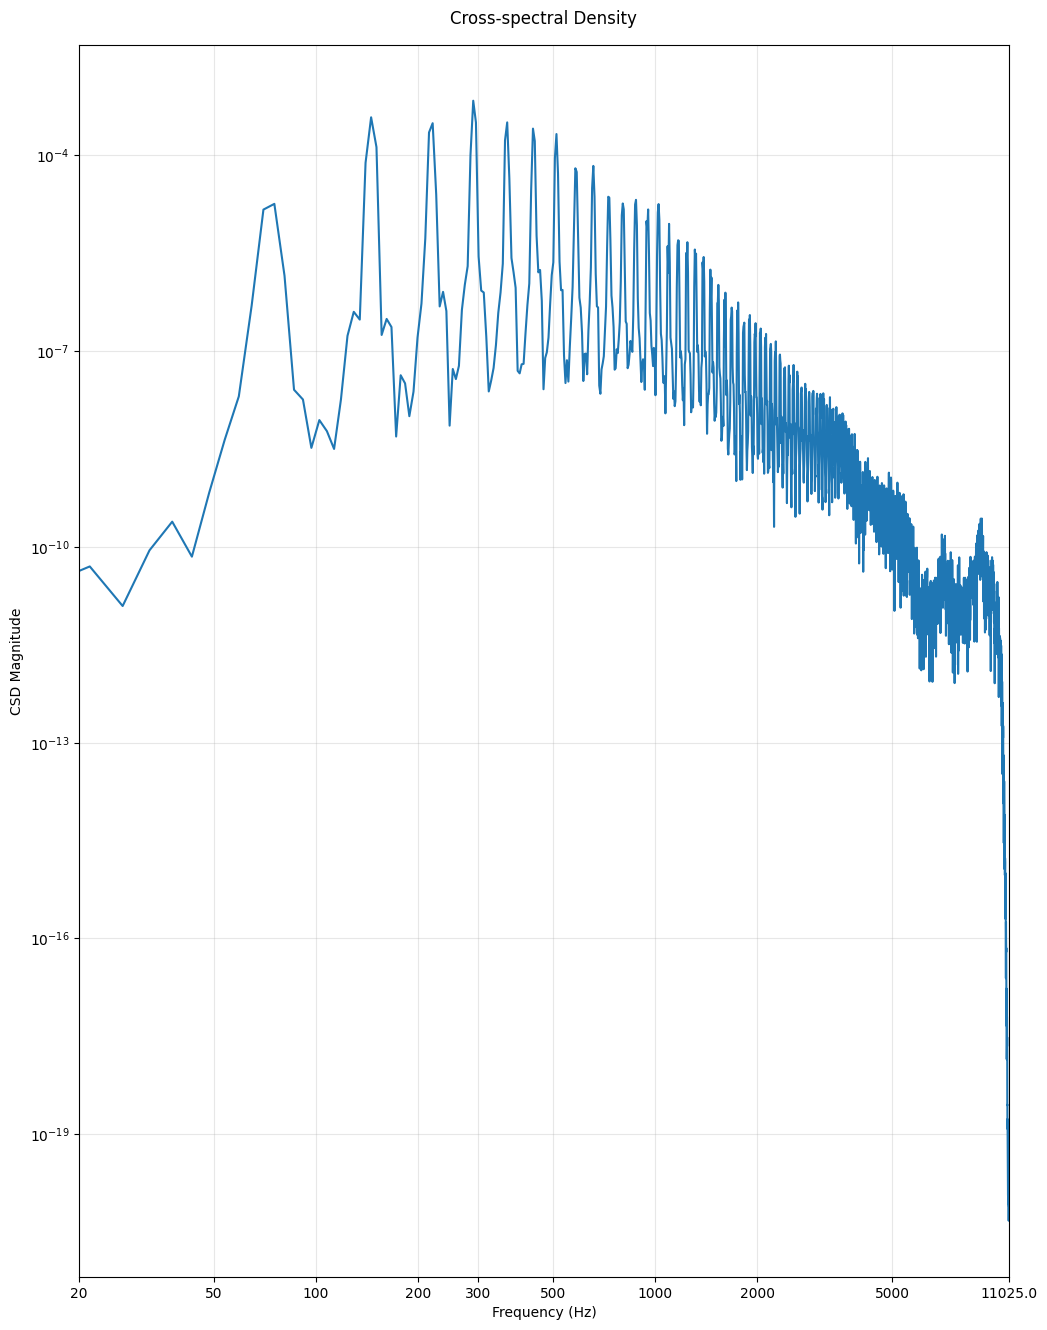

In [80]:
file1 = 'samples/singlenotes/york/sm57/york_015_D2_sm57.wav'
file2 = 'samples/singlenotes/yamaha/sm57/yamaha_015_D2_sm57.wav'
y1, sr = librosa.load(file1,sr=SAMPLE_RATE)
y2, sr = librosa.load(file2,sr=SAMPLE_RATE)

title = os.path.basename(file) 


y1 = trim(y1, sr, 0, TRIM_DURATION_SECONDS)
y2 = trim(y2, sr, 0, TRIM_DURATION_SECONDS)
y1 = apply_hann_window_fades(y1, sr, FADE_DURATION_SECONDS) 
y2 = apply_hann_window_fades(y2, sr, FADE_DURATION_SECONDS) 

# Create fig and ax objects
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 16))

plot_csd(y2, y1, SAMPLE_RATE,fig,ax1)

# plot_spectrum(y, sr, fig, ax3, title=title)
# plot_time(y, sr, fig, ax4, title=title)

plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
Audio(y, rate=sr)